<a href="https://colab.research.google.com/github/tq21/ML-Stuff/blob/master/Transfer_Learning_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preprocessing

In [2]:
!curl https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o /tmp/cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  73.1M      0 --:--:-- --:--:-- --:--:-- 73.1M


In [3]:
local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(train_cats_dir, 'cats')
validation_dogs_dir = os.path.join(train_dogs_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [4]:
# augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Load Pre-trained InceptionV3

In [7]:
!curl https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -o /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.8M  100 83.8M    0     0   205M      0 --:--:-- --:--:-- --:--:--  205M


In [8]:
# stores all pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

# load pre-trained weights to model
pre_trained_model.load_weights(local_weights_file)

# make all layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Transfer

In [13]:
# callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [14]:
# flatten output layer to last_output
x = layers.Flatten()(last_output)
# add layer to x
x = layers.Dense(1024, activation='relu')(x)
# add dropout rate of 0.2 to x
x = layers.Dropout(0.2)(x)
# add output layer to x
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.summary()

In [19]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_steps=50,
    callbacks=[callbacks]
)

Epoch 1/20
100/100 [==============================] - 19s 189ms/step - loss: 0.1367 - accuracy: 0.9580 - val_loss: 0.1417 - val_accuracy: 0.9640
Epoch 2/20
100/100 [==============================] - 20s 199ms/step - loss: 0.1106 - accuracy: 0.9585 - val_loss: 0.1330 - val_accuracy: 0.9670
Epoch 3/20
100/100 [==============================] - 20s 196ms/step - loss: 0.1331 - accuracy: 0.9560 - val_loss: 0.1342 - val_accuracy: 0.9670
Epoch 4/20
100/100 [==============================] - 19s 190ms/step - loss: 0.1082 - accuracy: 0.9670 - val_loss: 0.2078 - val_accuracy: 0.9530
Epoch 5/20
100/100 [==============================] - 19s 187ms/step - loss: 0.1092 - accuracy: 0.9625 - val_loss: 0.1311 - val_accuracy: 0.9670
Epoch 6/20
100/100 [==============================] - 19s 188ms/step - loss: 0.1259 - accuracy: 0.9600 - val_loss: 0.1259 - val_accuracy: 0.9720
Epoch 7/20
100/100 [==============================] - 19s 187ms/step - loss: 0.1198 - accuracy: 0.9650 - val_loss: 0.1342 - val_ac

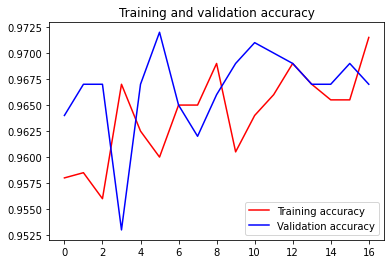

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()